# Supervised Text Classification Challenge
The goal is to improve the category classification performance for a set of text posts. The evaluation metric is the **macro F1 score**. A baseline method based on scikit-learn TfidfVectorizer and LogisticRegression was provided. The baseline score is about **0.3237**. 

The macro F1 score is given by the average of the F1 scores for each category (label), computed independently from their size. Therefore, it may not be the best metric to characterize the performance of a classifier in case of unbalanced class sizes. 

I explored various features, classifiers and hyperparameter settings. The final classifier is a majority vote ensemble of 2 logistic regression classifiers (on different set of features) and 1 gradient boosted tree classifier (of the XGBoost library) classifier leading to a final macro F1 score equal to **0.5574** ) Those are the main takeaways: 
1. Overall, logistic regression outperformed the other classifiers I tried (e.g. gradient boosted trees and random forest).
2. Gradient tree boosting of the XGBoost library was the 2nd best classifier after logistic regression.
3. Performing stemming (with preliminary stop word removal) improved the performance of logistic regression and XGBoost.
4. The addition of topic features via Latent Dirichlet Allocation improved slightly the performance for two of the classifiers.
5. The manually engineered features that gave a slight improvement to one of the classifiers are the length of a post (by number of tokens) and the question mark ('?') count.

The outcome (1) is not surprising, because the number of training samples (~ 14,000) is relatively low with respect to the number of features (e.g. ~ 10,000 extracted via scikit-learn TfidfVectorizer) for tree based methods to be fully effective. In this case a simple linear classifier is expected to do better than non-linear classifiers. I would expect tree based methods to outperform logistic regression if *number of samples* $\gg$ *number of features*. See for example the discussion on (http://fastml.com/classifying-text-with-bag-of-words-a-tutorial/).


### The Dataset
The dataset consist in 14048 text posts for training and 3599 for testing. There are 17 topic categories: personal, meetup, misc, relationships etc. The topic sizes are quite unbalanced. The proportions of categories in training and test sets seem to match.

The deatils about features, classifiers and hyperparameters are given in the remaining of this notebook.

**Author:** Lorenzo Rossi (lorenzo.rossi@gmail.com)

In [16]:
from csv import DictReader
from time import time
from numpy import mean, std
from collections import Counter
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import make_pipeline, FeatureUnion, Pipeline
from sklearn.metrics import f1_score, classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score
import xgboost as xgb
from nltk import stem
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')

from wordcloud import WordCloud, STOPWORDS
from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

IN_FOLDER = 'categories/data/' # folder for train and test.csv files

In [5]:
# Read training and test data (from baseline code)
def read_data(name):
    text, targets = [], []

    with open(''.join([IN_FOLDER, '{}.csv']).format(name)) as f:
        for item in DictReader(f):
            text.append(item['text'])
            targets.append(item['category'])

    return text, targets

# Loading training and testing data
text_train, targets_train = read_data('train')
text_test, targets_test = read_data('test')

### Quick inspection of the dataset

In [6]:
print('Training samples:', len(targets_train))
print('Testing samples:', len(targets_test))
print('Ttraining category count:', len(set(targets_train)))
print('Testing category count:', len(set(targets_test)),'\n')
print('Training set:', Counter(targets_train).most_common(),'\n')
print('Testing set:', Counter(targets_test).most_common())

Training samples: 14048
Testing samples: 3599
Ttraining category count: 17
Testing category count: 17 

Training set: [('personal', 3559), ('meetup', 2942), ('misc', 2718), ('relationships', 1159), ('qna', 909), ('lgbtq', 546), ('pop_culture', 519), ('family', 445), ('food', 266), ('school', 263), ('work', 199), ('animals', 147), ('fashion', 136), ('tatoos', 85), ('sports', 61), ('faith', 49), ('military', 45)] 

Testing set: [('personal', 910), ('meetup', 737), ('misc', 683), ('relationships', 337), ('qna', 221), ('pop_culture', 150), ('lgbtq', 147), ('family', 110), ('school', 74), ('food', 63), ('work', 49), ('fashion', 42), ('animals', 26), ('tatoos', 15), ('military', 14), ('faith', 11), ('sports', 10)]


## Wordclouds

(-0.5, 399.5, 199.5, -0.5)

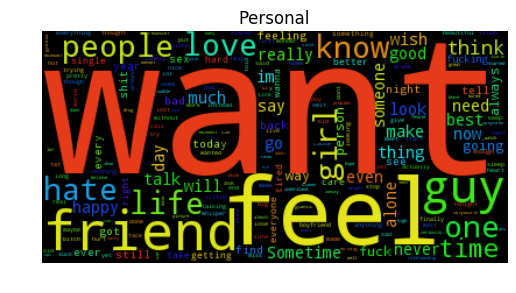

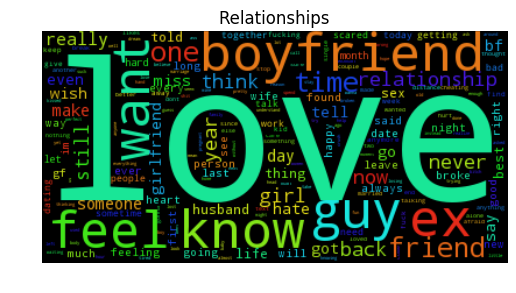

In [22]:
# Compare wordclouds for a couple of categories
personal_text = " ".join([post for (post,label) in zip(text_train,targets_train) if label=='personal'])
relationships_text = " ".join([post for (post,label) in zip(text_train,targets_train) if label=='relationships'])

personal_cloud = WordCloud(stopwords=STOPWORDS).generate(personal_text)
relationships_cloud = WordCloud(stopwords=STOPWORDS).generate(relationships_text)


plt.figure(1)
plt.imshow(personal_cloud)
plt.title('Personal')
plt.axis("off")
plt.figure(2)
plt.imshow(relationships_cloud)
plt.title('Relationships')
plt.axis("off")

### Baseline Classifier
The baseline classifier uses scikit-learn TdifVectorizer and LogisticRegression with default parameters.

In [7]:
text_train, targets_train = read_data('train')
text_test, targets_test = read_data('test')

baseline_model = make_pipeline(TfidfVectorizer(), LogisticRegression(), ).fit(text_train, targets_train)

baseline_prediction = baseline_model.predict(text_test)
baseline_score_training = f1_score(targets_train, baseline_model.predict(text_train), average='macro')
baseline_score = f1_score(targets_test, baseline_prediction, average='macro')
previous_score = baseline_score
best_score = baseline_score

print('baseline macro f1:', baseline_score, 'baseline macro f1 (training):', baseline_score_training)
print(classification_report(targets_test, baseline_prediction))

baseline macro f1: 0.323676828408 baseline macro f1 (training): 0.445114401387
             precision    recall  f1-score   support

    animals       0.71      0.19      0.30        26
      faith       0.00      0.00      0.00        11
     family       0.75      0.44      0.55       110
    fashion       0.00      0.00      0.00        42
       food       0.65      0.24      0.35        63
      lgbtq       0.77      0.40      0.53       147
     meetup       0.75      0.87      0.80       737
   military       0.00      0.00      0.00        14
       misc       0.45      0.52      0.48       683
   personal       0.50      0.75      0.60       910
pop_culture       0.77      0.11      0.20       150
        qna       0.54      0.30      0.38       221
relationships       0.65      0.46      0.54       337
     school       0.57      0.18      0.27        74
     sports       0.00      0.00      0.00        10
     tatoos       1.00      0.13      0.24        15
       work      

### Additional Features
The following simple features improved slightly the F1 macro score for the logistic regression classifier:
* Number of tokens in the post
* Number of question marks

Other features that did not seem to work: number of characters, punctuation counts for '.', ',', '!', stop word count, ratio of stop word count vs. token count.

#### Latent Dirichlet Allocation
The number of categories (labels) for the posts is 17. After various attempts, the LDA settings that give some improvements to the classification performance are: number of topics=13, $\alpha=.1$ $\beta=.01$. The number of samples for at least 4 categories is quite low (10 ~ 20), so 13 seems reasonable number of LDA topics.

In [8]:
class TextStats(BaseEstimator, TransformerMixin):
    """Returns the length of the post (as number of tokens) and the number of question marks"""

    def fit(self, x, y=None):
        return self

    def transform(self, posts):
        return [(len(tokenizer.tokenize(text)), text.count('?'))
                for text in posts]

# Latent Dirichlet Allocation
lda = Pipeline([('tf', CountVectorizer(strip_accents='unicode', stop_words='english')),
                ('lda',LatentDirichletAllocation(n_topics=13, max_iter=50, learning_method='online', #'online', 
                                                 learning_offset=50.,doc_topic_prior=.1, topic_word_prior=.01,
                                                 random_state=0))])
# All together
feats =  FeatureUnion([('text_len', TextStats()), ('lda', lda),
                       ('tfidf', TfidfVectorizer(strip_accents='unicode', min_df=5, ngram_range=(1, 2)))])

## Logistic Regression
The inverse of the regularization strength coefficient (C) was tuned to avoid a too large gap between F1 score metrics on training and testing sets (risk of overfitting). The ad hoc text related features and the LDA topics described above were added to the TF IDF features. As for the TF IDF parameters, there is a benefit to include bi-grams, but not to remove stop words. L1 regularization performed better than L2 one. Unexpectedly, the application of scaling to the additional (non TF IDF) features lead to worse performance.

This is the second best of the classifiers presented on this notebook for the macro F1 score. However, it is the best classifier for weighted and micro F1 scores.

In [9]:
t0 = time()

lda = Pipeline([('tf', CountVectorizer(strip_accents='unicode', stop_words='english')),
                ('lda',LatentDirichletAllocation(n_topics=13, max_iter=50, learning_method='online', #'online', 
                                                 learning_offset=50.,doc_topic_prior=.1, topic_word_prior=.01,
                                                 random_state=0)), ])

feats =  FeatureUnion([('text_len', TextStats()), ('lda', lda), 
                       ('tfidf', TfidfVectorizer(strip_accents='unicode', min_df=5, ngram_range=(1, 2)))])

lr_model = make_pipeline(feats, LogisticRegression(C=1., penalty='l1', random_state=0), ).fit(text_train, targets_train)
lr_prediction = lr_model.predict(text_test)

print('training score:', f1_score(targets_train, lr_model.predict(text_train), average='macro'))
lr_macro_f1 = f1_score(targets_test, lr_prediction, average='macro')
print('testing score:', lr_macro_f1)

print("done in %0.3fs." % (time() - t0))
print(classification_report(targets_test, lr_prediction))

training score: 0.53048087702
testing score: 0.510861119721
done in 342.358s.
             precision    recall  f1-score   support

    animals       0.78      0.54      0.64        26
      faith       0.50      0.18      0.27        11
     family       0.69      0.64      0.66       110
    fashion       0.67      0.14      0.24        42
       food       0.68      0.43      0.52        63
      lgbtq       0.76      0.52      0.62       147
     meetup       0.78      0.85      0.81       737
   military       1.00      0.29      0.44        14
       misc       0.50      0.54      0.52       683
   personal       0.53      0.73      0.62       910
pop_culture       0.75      0.18      0.29       150
        qna       0.58      0.49      0.53       221
relationships       0.68      0.48      0.56       337
     school       0.62      0.35      0.45        74
     sports       1.00      0.20      0.33        10
     tatoos       1.00      0.53      0.70        15
       work       

## Stemming
Preprocessing the posts with stop word removal and then Porter stemming improved the F1 macro scores of both logistic regression and XGBoost classifiers.

In [10]:
stemmer = stem.PorterStemmer()

def porter_stem(sentence):
    # Porter stemming 
    stemmed_sequence = [stemmer.stem(word) for word in tokenizer.tokenize(sentence)
                        if word not in stopwords.words('english')]
    return ' '.join(stemmed_sequence)

stemmed_train = [porter_stem(post) for post in text_train]
stemmed_test = [porter_stem(post) for post in text_test]

### Logistic Regression with Porter Stemming
This is the best performing classifier according to the F1 macro score, (but not according to the micro or weghted scores). In this case, the addition of LDA topics (but not the ad-hoc text features) leads to an improvement in the classification performance. 

In [11]:
t0 = time()


lda = Pipeline([('tf', CountVectorizer(strip_accents='unicode', stop_words='english')),
                ('lda',LatentDirichletAllocation(n_topics=13, max_iter=20, learning_method='online', 
                                                 learning_offset=50.,doc_topic_prior=.1, topic_word_prior=.01,
                                                 random_state=0)), ])

lda_tfidf_features =  FeatureUnion([('lda', lda),
                                    ('tfidf', TfidfVectorizer(strip_accents='unicode', min_df=4))])

stem_lr_model = make_pipeline(lda_tfidf_features, LogisticRegression(C=1.5, penalty='l1', random_state=0)
                             ).fit(stemmed_train, targets_train)
stem_lr_prediction = stem_lr_model.predict(stemmed_test)

print('training score:', f1_score(targets_train, stem_lr_model.predict(stemmed_train), average='macro'))
stem_lr_macro_f1 = f1_score(targets_test, stem_lr_prediction, average='macro')
print('testing score:', stem_lr_macro_f1)

print("done in %0.3fs." % (time() - t0))
print(classification_report(targets_test, stem_lr_prediction))

training score: 0.615406021342
testing score: 0.546369364043
done in 117.937s.
             precision    recall  f1-score   support

    animals       0.70      0.62      0.65        26
      faith       0.67      0.36      0.47        11
     family       0.68      0.63      0.65       110
    fashion       0.43      0.14      0.21        42
       food       0.60      0.51      0.55        63
      lgbtq       0.78      0.59      0.67       147
     meetup       0.77      0.82      0.79       737
   military       0.78      0.50      0.61        14
       misc       0.47      0.53      0.50       683
   personal       0.51      0.67      0.58       910
pop_culture       0.55      0.16      0.25       150
        qna       0.56      0.42      0.48       221
relationships       0.70      0.44      0.54       337
     school       0.67      0.50      0.57        74
     sports       0.50      0.40      0.44        10
     tatoos       0.87      0.87      0.87        15
       work      

### XGboost with Stemming
In the case of the XGBoost classifier the LDA topic and other ad-hoc text features did not seem to improve the performance. The reg_alpha parameter seems usually set to 0 for XGBoost tunings. Here setting it to 4 worked as a way to decrease the risk of overfitting.

In [12]:
t0 = time()

stem_xgb_model = make_pipeline(TfidfVectorizer(strip_accents='unicode', min_df=5, ngram_range=(1, 2)), 
                               xgb.XGBClassifier(max_depth=10, n_estimators=80, learning_rate=0.1, colsample_bytree=.7, 
                                                 gamma=.01, reg_alpha=4, objective='multi:softmax')
                              ).fit(stemmed_train, targets_train) 

stem_xgb_prediction = stem_xgb_model.predict(stemmed_test)

stem_xgb_macro_f1 = f1_score(targets_test, stem_xgb_prediction, average='macro')

print('training score:', f1_score(targets_train, stem_xgb_model.predict(stemmed_train), average='macro'))
stem_xgb_macro_f1 = f1_score(targets_test, stem_xgb_prediction, average='macro')
print('testing score:', stem_xgb_macro_f1)

print("done in %0.3fs." % (time() - t0))
print(classification_report(targets_test, stem_xgb_prediction))

training score: 0.595850654928
testing score: 0.475448346869
done in 83.985s.
             precision    recall  f1-score   support

    animals       0.70      0.62      0.65        26
      faith       0.00      0.00      0.00        11
     family       0.63      0.60      0.62       110
    fashion       0.50      0.07      0.12        42
       food       0.66      0.40      0.50        63
      lgbtq       0.77      0.61      0.68       147
     meetup       0.76      0.74      0.75       737
   military       0.55      0.43      0.48        14
       misc       0.44      0.56      0.49       683
   personal       0.50      0.64      0.56       910
pop_culture       0.56      0.17      0.26       150
        qna       0.54      0.43      0.47       221
relationships       0.71      0.44      0.54       337
     school       0.67      0.54      0.60        74
     sports       0.00      0.00      0.00        10
     tatoos       0.88      0.93      0.90        15
       work       

## Majority Voting Ensembling
The results of the three above classifiers are ensembled via a simple majority voting scheme. In case of no majority, the prediction of the logistic regression with stemming (i.e. the classifier with the highest macro F1 score) is picked.

In [13]:
def majority_element(a):
    c = Counter(a)
    value, count = c.most_common()[0]
    if count > 1:
        return value
    else:
        return a[0]

merged_predictions = [[s[0],s[1],s[2]] for s in zip(stem_lr_prediction, lr_prediction, stem_xgb_prediction)]
majority_prediction = [majority_element(p) for p in merged_predictions]

print('majority vote ensemble:', f1_score(targets_test, majority_prediction, average='macro')) 
print(classification_report(targets_test, majority_prediction))

majority vote ensemble: 0.54978514442
             precision    recall  f1-score   support

    animals       0.76      0.62      0.68        26
      faith       0.67      0.18      0.29        11
     family       0.69      0.66      0.68       110
    fashion       0.67      0.14      0.24        42
       food       0.62      0.48      0.54        63
      lgbtq       0.78      0.59      0.67       147
     meetup       0.79      0.82      0.81       737
   military       0.75      0.43      0.55        14
       misc       0.48      0.55      0.52       683
   personal       0.52      0.69      0.60       910
pop_culture       0.61      0.17      0.26       150
        qna       0.59      0.47      0.52       221
relationships       0.73      0.46      0.56       337
     school       0.67      0.50      0.57        74
     sports       0.67      0.40      0.50        10
     tatoos       0.93      0.87      0.90        15
       work       0.51      0.45      0.48        49

avg 

### Comparison of different F1 score metrics for the classifiers
The score comparison below shows that micro and weighted F1 scores are generally similar for the same classifier, unlike macro F1 score. In the case of micro F1 score, the baseline classifier is relatively close to the other classifiers performance wise. Besides, the best classifier for the micro/weighted F1 scores is not the top classifier on macro F1 score. 

In [14]:
classifiers = ['Baseline','Logistic Regression with stemming', 'Logistic Regression', 'XGB with stemming', 'Majority voting ensemble']
predictions = (baseline_prediction, stem_lr_prediction, lr_prediction, stem_xgb_prediction, majority_prediction)
for pred, clfs in zip(predictions, classifiers):
    print(''.join((clfs,':')))
    print('macro:',f1_score(targets_test, pred, average='macro'))
    print('weighted:',f1_score(targets_test, pred, average='weighted'))
    print('micro:',f1_score(targets_test, pred, average='micro'))
    print()

Baseline:
macro: 0.323676828408
weighted: 0.545684287029
micro: 0.572103362045

Logistic Regression with stemming:
macro: 0.546369364043
weighted: 0.584299470013
micro: 0.592386774104

Logistic Regression:
macro: 0.510861119721
weighted: 0.602487440446
micro: 0.613781606002

XGB with stemming:
macro: 0.475448346869
weighted: 0.565719822074
micro: 0.572103362045

Majority voting ensemble:
macro: 0.54978514442
weighted: 0.600682841248
micro: 0.608502361767

